# Perspective Correction Evaluation
The purpose of this Notebook is to evaluate different approaches of Perspective Correction and determine their suitability for PCB Defect Detection.

## Imports

In [1]:
import os
import random

import numpy as np
import cv2
import importlib

import source.utils.pcb_visualization as pcb_visualization
import source.load_raw_data.kaggle_dataset as kaggle_dataset 

c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\tensorflow\python\framework\dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [33]:
importlib.reload(pcb_visualization)
ROOT_DIR = os.path.join(os.path.abspath(__name__), '..', '..')
pcb_visualizer = pcb_visualization.PCBVisualizerforCV2()

## Initialization

In [30]:
pcb_visualizer = pcb_visualization.PCBVisualizerforCV2()

## Load Data

In [6]:
paths = []
targets = []

kaggle_data = kaggle_dataset.get_dataframe()

for _, sample in kaggle_data.iterrows():
    if sample['path'] not in paths:
        paths.append(os.path.join(ROOT_DIR, sample['path']))

#TODO: Append additional Datasets here.

# Shuffle
indices = list(range(len(paths)))
random.seed(34)  
random.shuffle(indices)
shuffled_paths = [paths[i] for i in indices[:9]]
images = [cv2.imread(path) for path in shuffled_paths]

In [21]:
warped_images = []
corners_list = []
for image in images:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dst = cv2.cornerHarris(image, 2, 3, 0.04)  # Harris Algorithm.
    dst = cv2.dilate(dst, None)
    _, dst = cv2.threshold(dst, 0.6 * dst.max(), 255, 0)
    corners = np.argwhere(dst) # Return non zero args

    #corners = np.intp(corners).reshape(-1, 2)
    
    sorted_corners = corners[np.argsort(corners[:, 1])]
    corners_list.append(sorted_corners)

    #If we do not get exactly 4 corners, return the original image
    if corners is None or len(corners) != 4:
        print('Number of detected Corners: ', len(corners))
        continue
    
    print('Top Left: ', sorted_corners[1], 'Top Right: ', sorted_corners[0], 'Bottom Left: ', sorted_corners[3], 'Bottom Right: ', sorted_corners[2])

    width_top = np.linalg.norm(sorted_corners[0] - sorted_corners[1])
    width_bottom = np.linalg.norm(sorted_corners[2] - sorted_corners[3])
    height_left = np.linalg.norm(sorted_corners[0] - sorted_corners[2])
    height_right = np.linalg.norm(sorted_corners[1] - sorted_corners[3])

    detected_width = (width_top + width_bottom) / 2
    detected_height = (height_left + height_right) / 2
    aspect_ratio = detected_width / detected_height

    # Determine dimensions for the desired rectangle
    if aspect_ratio > 1:
        desired_width = int(detected_width)
        desired_height = int(desired_width / aspect_ratio)
    else:
        desired_height = int(detected_height)
        desired_width = int(desired_height * aspect_ratio)

    desired_corners = np.array([
        [0, 0],
        [desired_width-1, 0],
        [0, desired_height-1],
        [desired_width-1, desired_height-1]
    ], dtype='float32')
    
    M = cv2.getPerspectiveTransform(np.float32(sorted_corners), desired_corners)
    warped_images.append(cv2.warpPerspective(image, M, (desired_width, desired_height)))

Number of detected Corners:  18
Number of detected Corners:  81
Number of detected Corners:  27
Number of detected Corners:  105
Number of detected Corners:  24
Number of detected Corners:  9
Number of detected Corners:  18
Number of detected Corners:  93
Number of detected Corners:  27


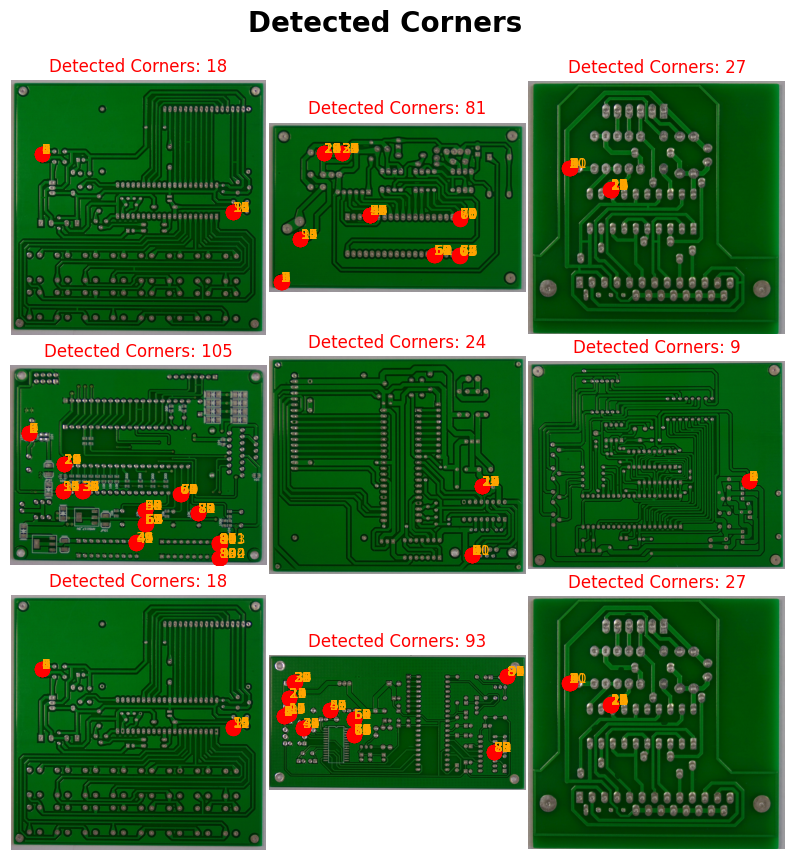

<Figure size 640x480 with 0 Axes>

In [31]:
pcb_visualizer.plot_detected_corners(images, corners_list)
